

### The CIFAR-100 Dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
import numpy as np
import matplotlib.pyplot as plt
import json
%matplotlib inline


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import label_binarize

We will use the [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). This image dataset has 100 classes with 500 training images and 100 test images per class. 

The goal is to use the tf.data module preprocessing tools to construct a data preporcessing pipeline including filtering and function mapping over the dataset to classify the images.

#### Load the dataset

In [2]:
# Load the data

(train_data, train_labels), (test_data, test_labels) = cifar100.load_data(label_mode='fine')



#### Display sample images and labels from the training set

In [3]:
print(train_data.shape, train_labels.shape,test_data.shape, test_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


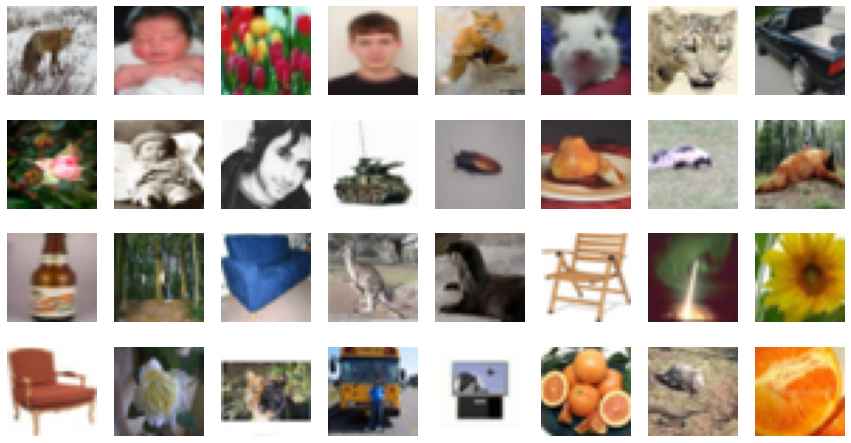

In [4]:
# Displaysample images and labels

plt.figure(figsize=(15,8))
inx = np.random.choice(train_data.shape[0], 32, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(4, 8, n+1)
    plt.imshow(train_data[i])
    plt.axis('off')

In [5]:
#  function to create a tf.data.Dataset object with given inputs
create_dataset = lambda data, labels : tf.data.Dataset.from_tensor_slices((data, labels))

In [6]:
#  cell to convert the training and test data and labels into datasets

train_dataset = create_dataset(train_data, train_labels)
test_dataset = create_dataset(test_data, test_labels)

#### Filter the Dataset

The following fucntions can be used to process our dataset.
[`tf.equal`](https://www.tensorflow.org/api_docs/python/tf/math/equal), 
[`tf.cast`](https://www.tensorflow.org/api_docs/python/tf/dtypes/cast) and 
[`tf.math.reduce_any`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_any). 

In [8]:

def filter_classes(dataset, classes):
    """
    a filter function to filter specfic labels in the dataset 
    """
    
    def filter_function(image, label):
        temp = tf.math.equal(label, classes)
        return tf.math.reduce_any(temp)
        
    return dataset.filter(filter_function)

In [9]:
# cell to filter the datasets using your function

cifar_classes = [1,2,10] # Your datasets should contain only classes in this list

train_dataset = filter_classes(train_dataset, cifar_classes)
test_dataset = filter_classes(test_dataset, cifar_classes)

In [10]:
from keras.utils import to_categorical

def map_labels(dataset):
    #This function should map over the dataset to convert the label to a one-hot vector. 
    
    def one_hot_encode(image, label):
        if tf.math.reduce_any(tf.math.equal(label,1)):
            label = tf.constant([1., 0., 0.])
        elif tf.math.reduce_any(tf.math.equal(label,2)):
            label = tf.constant([0., 1., 0.])
        else:
            label = tf.constant([0., 0., 1.])
    
        return (image, label)
    
    return dataset.map(one_hot_encode)

In [11]:
# cell to one-hot encode the training and test labels.

train_dataset = map_labels(train_dataset)
test_dataset = map_labels(test_dataset)

In [12]:
train_dataset.element_spec

(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(3,), dtype=tf.float32, name=None))

In [1]:


def map_images(dataset):
    """
    This function should map over the dataset to process the image according to the 
    above specification. The function should then return the mapped Dataset object.
    """
    
    def to_black_and_white(image, label):
        
        image = tf.dtypes.cast(image, tf.float32)
        
        image = image/255.
        
        image = tf.math.reduce_mean(image, axis=-1, keepdims=True)
        
        return (image, label)
    
    return dataset.map(to_black_and_white)

In [14]:
# cell to apply your mapping function to the datasets

train_dataset_bw = map_images(train_dataset)
test_dataset_bw = map_images(test_dataset)

In [15]:
train_dataset_bw.element_spec

(TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(3,), dtype=tf.float32, name=None))

We will now batch and shuffle the Dataset objects.

In [16]:
# cell to batch the training dataset and expand the final dimensinos

train_dataset_bw = train_dataset_bw.batch(10)
train_dataset_bw = train_dataset_bw.shuffle(100)

test_dataset_bw = test_dataset_bw.batch(10)
test_dataset_bw = test_dataset_bw.shuffle(100)

In [17]:
train_dataset_bw.element_spec

(TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))

#### Train a neural network model

Now we will train a model using the `Dataset` objects. We will use the model specification and function from the first part of this assignment, only modifying the size of the input images.

In [18]:
def get_model(input_shape):
    """
    This function should build and compile a CNN model according to the above specification,
    using the functional API. Your function should return the model.
    """
    
    inputs = Input(shape=input_shape)
    
    Conv1 = Conv2D(filters=28, kernel_size=(5,5), activation='relu', padding='SAME')(inputs)
    MaxPool1 = MaxPooling2D(pool_size=(2,2))(Conv1)
    
    Conv2 = Conv2D(filters=14, kernel_size=(5,5), activation='relu', padding='SAME')(MaxPool1)
    MaxPool2 = MaxPooling2D(pool_size=(2,2))(Conv2)
    
    Conv3 = Conv2D(filters=10, kernel_size=(3,3), activation='relu', padding='SAME')(MaxPool2)
    MaxPool3 = MaxPooling2D(pool_size=(2,2))(Conv3)
    
    
    flat = Flatten()(MaxPool3)
    fc1 = Dense(units=100, activation='relu')(flat)
    
    fc2 = Dense(units=3, activation='softmax')(fc1)
    
    model = Model(inputs=inputs, outputs=fc2)
    
    opt = Adam(learning_rate=0.0005)
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [19]:
# Build and compile a new model with our original spec, using the new image size
    
cifar_model = get_model((32, 32, 1))

In [20]:
# Train the model for 15 epochs

history = cifar_model.fit(train_dataset_bw, validation_data=test_dataset_bw, epochs=50)

Epoch 1/50
150/150 [==============================] - 2s 13ms/step - loss: 1.0322 - accuracy: 0.4707 - val_loss: 0.9664 - val_accuracy: 0.5033
Epoch 2/50
150/150 [==============================] - 2s 12ms/step - loss: 0.9183 - accuracy: 0.5700 - val_loss: 0.8795 - val_accuracy: 0.5733
Epoch 3/50
150/150 [==============================] - 2s 12ms/step - loss: 0.8530 - accuracy: 0.6227 - val_loss: 0.8429 - val_accuracy: 0.6167
Epoch 4/50
150/150 [==============================] - 2s 13ms/step - loss: 0.7895 - accuracy: 0.6573 - val_loss: 0.8279 - val_accuracy: 0.6100
Epoch 5/50
150/150 [==============================] - 2s 14ms/step - loss: 0.7351 - accuracy: 0.6873 - val_loss: 0.7470 - val_accuracy: 0.6733
Epoch 6/50
150/150 [==============================] - 2s 13ms/step - loss: 0.6721 - accuracy: 0.7247 - val_loss: 0.7245 - val_accuracy: 0.6833
Epoch 7/50
150/150 [==============================] - 2s 12ms/step - loss: 0.6204 - accuracy: 0.7400 - val_loss: 0.7121 - val_accuracy: 0.6867

#### Plot the learning curves

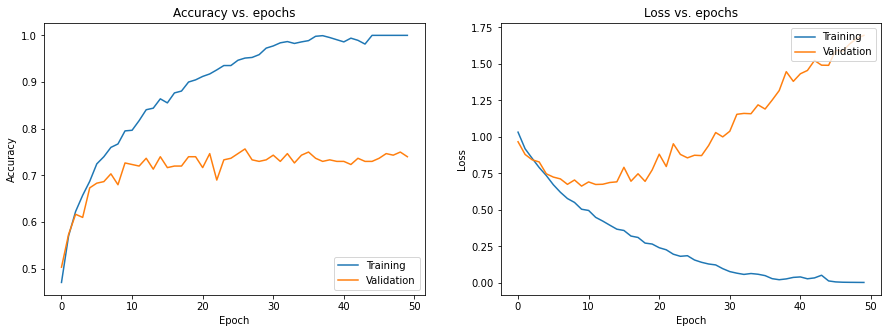

In [21]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    try:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    except KeyError:
        plt.plot(history.history['categorical_accuracy'])
        plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [22]:
# Create an iterable from the batched test dataset

test_dataset = test_dataset.batch(10)
iter_test_dataset = iter(test_dataset)